# Integration of SVM and MVO 

This notebook computes and visualizes the results of the computational experiments

In [31]:
import numpy as np
from pandas.tseries.offsets import Day, MonthBegin
pth = 'cache/Experiments/'
local_experiments_pth = 'cache/Local Experiments/'
cache_path = 'cache/'
img_path = "Images/"
from python.packages import *
from python.analysis_tools import *
import pickle
%matplotlib inline

### Wealth Experiments

* for a given turnover, read in the 3 configurations 

* generate cumulative wealth plots

* calculate sharpe ratios

* look at factors over time

### Biases 

The results here are biased because although the portfolios have turnover constraints they also do not consider transaction costs - for comparison purposes this is okay but for actually financial reporting this is not

Furthermore, the asset universe is has survivorship bias 

There is one less out of sample return because the estimates (based on past info) can be obtained but the realized returns cannot be obtained for the last available estimate.

In [32]:
## Import Monthly Returns
rets = pd.read_pickle(cache_path + "RETS.pkl")
## Import feature vectors
wrds_svm = pd.read_pickle(cache_path + "WRDS_ASOF.pkl")
## Import Daily Prices
Prices = pd.read_pickle(cache_path + "Daily_Prices.pkl")
## Get the trade dates
StockDates = wrds_svm.reset_index().loc[:, ['Date', 'MonthStart', 'MonthEnd']].drop_duplicates()

  #risk free rate data
FF_RiskFree = pd.read_csv(cache_path + "F-F_Research_Data_Factors.CSV")
FF_RiskFree.Date = pd.to_datetime(FF_RiskFree['Date'], format='%Y%m', errors='coerce')
FF_RiskFree.index = FF_RiskFree.Date
FF_RiskFree.drop(FF_RiskFree.columns[0:4], axis=1, inplace = True)


In [33]:
daily_rets = Prices.pct_change() + 1
new_index = daily_rets.index[0:-1] #VERY IMPORTANT
daily_rets.drop(daily_rets.head(1).index,inplace=True)
daily_rets.index = new_index
Prices['StartMonth'] = Prices.index + Day(1) + MonthBegin(-1)
#this calculate the month of the stock returns
daily_rets['StartMonth'] = daily_rets.index + Day(1) + MonthBegin(-1)
# daily_rets[['AAPL', 'StartMonth']].head()
# daily_rets.dropna(inplace = True)
# daily_rets.head()

In [34]:
# daily_portfolio = pd.merge(weights_mvo, daily_rets.reset_index()[['Date', 'StartMonth']], how='left', left_index = True, right_on = 'StartMonth')
# daily_portfolio.index = daily_portfolio.Date
#Rets.index.isin(StockDates.MonthStart.values)
(daily_rets).groupby('StartMonth').prod().iloc[8:].head() - 1

,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMB,WMT,WY,XEL,XLNX,XOM,XRAY,XRX,YUM,ZBRA
StartMonth,,,,,,,,,,,,,,,,,,,,,
2000-07-01,-0.075030,0.149590,0.194030,-0.043729,-0.105083,-0.184231,-0.018750,-0.034648,-0.424388,0.071684,...,0.040179,-0.041758,0.080448,0.132415,-0.166544,0.005695,0.142562,-0.245399,-0.098253,0.158960
2000-08-01,0.286440,-0.007130,0.565625,0.025185,0.182414,0.552152,-0.058899,0.194307,0.386707,0.076923,...,0.086912,-0.105505,-0.053455,0.119107,0.294014,0.036879,0.014466,0.069129,0.157385,0.062344
2000-09-01,-0.617734,0.412926,0.045908,0.108381,0.204822,-0.171393,0.042857,0.076122,-0.128540,0.072135,...,-0.088809,-0.050227,-0.165289,0.100985,-0.051700,0.108334,-0.003583,-0.057692,0.031381,-0.167840
2000-10-01,-0.154641,-0.102922,-0.125954,0.107287,-0.052148,-0.291667,0.219178,-0.000965,-0.157850,-0.044117,...,-0.005797,0.009461,0.193338,-0.050657,-0.225969,0.006835,-0.001792,-0.440816,-0.016227,-0.055007
2000-11-01,-0.167680,0.107649,-0.192140,0.000000,-0.128641,-0.119748,0.151331,0.002896,0.285714,0.096923,...,-0.185131,0.096384,0.013947,0.023752,-0.406858,-0.030599,0.086176,-0.264868,0.129897,0.007463


In [35]:
from itertools import product
turnovers = ["0_75", "1", "1_25"]
turnover_strings = ["$C_0 = 0.75$", "$C_0 = 1.00$", "$C_0 = 1.25$"]
# cardinalities  = ["Card01", "Card03", "Card05", "Card07", "Card09"]
# card_strings = [ "$K = 0.1N$", "$K = 0.3N$", "$K = 0.5N$", "$K = 0.75N$", "$K = 0.9N$"]
cardinalities  = ["Card05", "Card07", "Card09"]
card_strings = ["$K = 0.5N$", "$K = 0.75N$", "$K = 0.9N$"]
oot_returns_mvo_dict = {}
oot_returns_svm_dict = {}
oot_returns_adm_dict = {}

for (turnover, card) in product(turnovers, cardinalities):

    with open(pth + ""+card+"_oot_results__turnover"+turnover+"by6.pkl",'rb') as fp:
      mvo_results = pickle.load(fp)
    # with open(pth + "svm_oot_results_turnover0_75by6.pkl", 'rb') as fp:
    #   svm_results = pickle.load(fp)
    with open(pth + ""+card+"_negvol_"+turnover+"by6.pkl", 'rb') as fp:
      svm_results = pickle.load(fp)

    with open(local_experiments_pth + ""+card+"_Vol_"+turnover+"by6.pkl", 'rb') as fp:
      svm_results = pickle.load(fp)

    with open(pth + ""+card+"_oot_"+turnover+".pkl", 'rb') as fp:
      adm_results = pickle.load(fp)

    weights_mvo, oot_returns_mvo, market_mvo, wis_mvo, bias_mvo, soln_mods_mvo = mvo_results
    weights_svm, oot_returns_svm, market_svm, wis_svm, bias_svm, soln_mods_svm = svm_results
    weights_adm, oot_returns_adm, market_adm, wis_adm, bias_adm, soln_mods_adm, times = adm_results

    oot_returns_mvo_dict[(card, turnover)] = (weights_mvo.iloc[:-1]*rets).sum(axis = 1)
    oot_returns_svm_dict[(card, turnover)] = (weights_svm.iloc[:-1]*rets).sum(axis = 1)
    oot_returns_adm_dict[(card, turnover)] = (weights_adm.iloc[:-1]*rets).sum(axis = 1)

rf = FF_RiskFree[FF_RiskFree.index.isin(oot_returns_adm.index)]
rf = rf.RF;

In [62]:
card.lstrip("Card")[0]

'0'

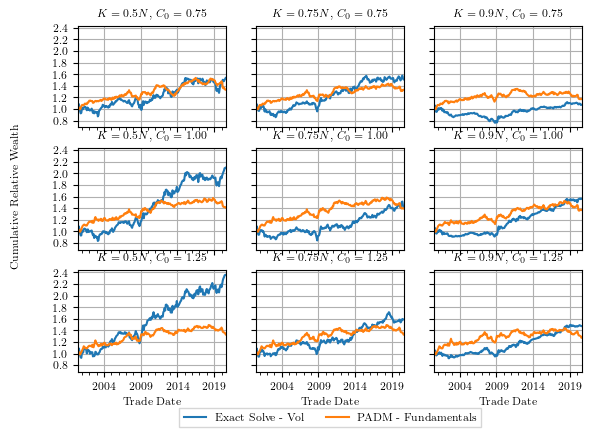

In [66]:
max_y = 0
min_y = 0.8
fig, axs = plt.subplots(len(turnovers), len(cardinalities),
                        sharex=True, sharey = True, figsize=(6.5,4.5))
for (i ,j) in product(range(len(turnovers)), range(len(cardinalities))):
    turnover = turnovers[i]
    card = cardinalities[j]
    svm_wealth = wealth(oot_returns_svm_dict[(card, turnover)])
    mvo_wealth = wealth(oot_returns_mvo_dict[(card, turnover)])
    adm_wealth = wealth(oot_returns_adm_dict[(card, turnover)])
    T = len(adm_wealth)
    (svm_wealth/mvo_wealth).plot(label = 'Exact Solve - Vol', fontsize = 8, ax=axs[i, j])
    (adm_wealth/mvo_wealth).plot(label = 'PADM - Fundamentals', fontsize = 8, ax=axs[i, j])
    card_string = card_strings[j]
    turnover_string = turnover_strings[i]
    axs[i, j].set_title(card_string + ", " + turnover_string, fontsize = 8)
    max_ = max(np.max((adm_wealth/mvo_wealth)), np.max((svm_wealth/mvo_wealth)))
    if max_ > max_y:
        max_y = max_
axs[2, 1].legend(loc='upper center',
             bbox_to_anchor=(0.5, -0.3),
                 fancybox=False,
                 shadow=False, ncol=3,
                 fontsize = 8)

for ax in axs:
    for sub_ax in ax:
        sub_ax.yaxis.set_tick_params(which='minor', bottom=False)
        sub_ax.set_yticks([min_y+i*0.2 for i in range(2+int((max_y - min_y)/0.2))])
        sub_ax.grid()
        sub_ax.set_xlabel("Trade Date",fontsize = 8)
# fig.supxlabel('Trade Date',fontsize = 8)
fig.supylabel("Cumulative Relative Wealth",fontsize = 8)
#plt.setp(axs, yticks = [i*0.2 for i in range(2+int(max_y/0.2))])
#plt.tight_layout()
plt.savefig(img_path + "p12.svg", dpi = dpi_setting)

In [11]:
ax[0]

<AxesSubplot:title={'center':'$K = 0.5N$, $C = 0.75$'}, xlabel='StartMonth'>

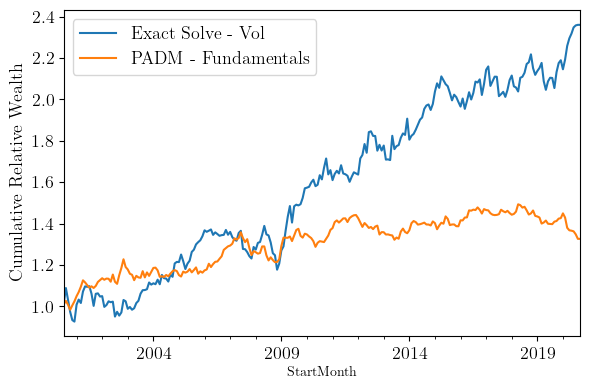

In [59]:

plt.figure(figsize = (6,4))
#(wealth(oot_returns_mvo.iloc[:T])/wealth(oot_returns_mvo.iloc[:T])).plot(label = 'MVO');
(wealth(oot_returns_svm.iloc[:T])/wealth(oot_returns_mvo.iloc[:T])).plot(label = 'Exact Solve - Vol',fontsize = 16, axs);
(wealth(oot_returns_adm.iloc[:T])/wealth(oot_returns_mvo.iloc[:T])).plot(label = 'PADM - Fundamentals',fontsize = 16);
#(wealth(oot_returns_mvo.iloc[:T])/wealth(oot_returns_mvo.iloc[:T])).plot(label = 'MVO');
#wealth(rets.iloc[:,:N].max(axis=1)).plot(label = 'Max Possible');
plt.ylabel("Cumulative Relative Wealth",fontsize = 16)
plt.legend(fontsize = 16);
plt.tight_layout()
plt.savefig(img_path + "p12"+turnover+"_"+card+".svg", dpi = dpi_setting)

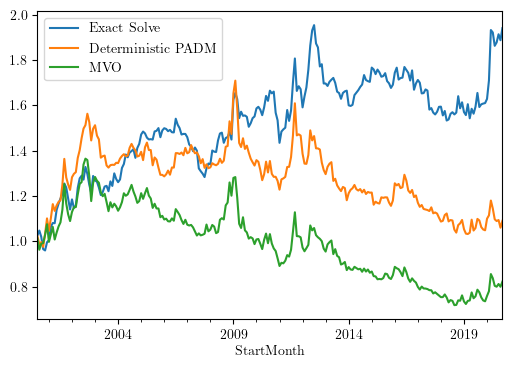

In [47]:
T = len(oot_returns_adm)
plt.figure(figsize = (6,4))
(wealth(oot_returns_svm.iloc[:T])/wealth(market_mvo.iloc[:T])).plot(label = 'Exact Solve');
(wealth(oot_returns_adm.iloc[:T])/wealth(market_mvo.iloc[:T])).plot(label = 'Deterministic PADM');
(wealth(oot_returns_mvo.iloc[:T])/wealth(market_mvo.iloc[:T])).plot(label = 'MVO');
plt.legend();
#(wealth(market_svm.iloc[:T])).plot(label = 'MVO');

In [51]:
pd.DataFrame([RetStats(oot_returns_mvo, rf/100), RetStats(oot_returns_svm, rf/100), RetStats(oot_returns_adm, rf/100)], index = ["MVO", "SVM MVO - Exact", "SVM MVO - ADM"], columns = ["$\mu$", "$\sigma$", "Sharpe Ratio"])

,$\mu$,$\sigma$,Sharpe Ratio
MVO,0.109198,0.120621,0.905300
SVM MVO - Exact,0.152083,0.162085,0.938287
SVM MVO - ADM,0.123299,0.131658,0.936508


In [52]:
print('mvo turnover proxy', weights_mvo.diff().abs().sum(axis = 1).sum())
print('svm turnover proxy', weights_svm.diff().abs().sum(axis = 1).sum())
print('adm turnover proxy', weights_adm.diff().abs().sum(axis = 1).sum())

mvo turnover proxy 50.416693762080726
svm turnover proxy 50.32524136739624
adm turnover proxy 50.41669135324448


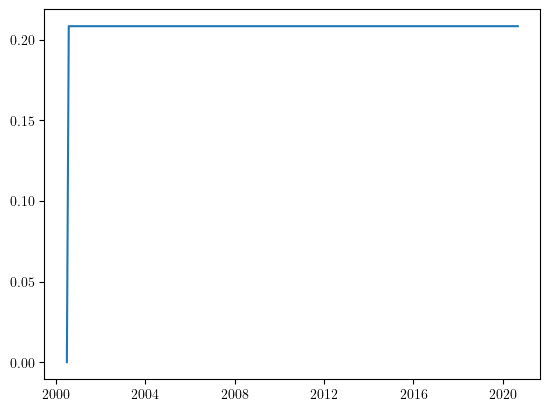

In [53]:
plt.plot(weights_adm.diff().abs().sum(axis = 1))

In [54]:
weights_svm.diff().abs().sum(axis = 1) #turnover limit respected

StartMonth
2000-07-01    0.000000
2000-08-01    0.208333
2000-09-01    0.208333
2000-10-01    0.208333
2000-11-01    0.208333
                ...   
2020-05-01    0.208333
2020-06-01    0.208333
2020-07-01    0.208333
2020-08-01    0.208333
2020-09-01    0.208333
Length: 243, dtype: float64

In [55]:
np.concatenate([wis_adm, np.expand_dims(bias_adm, axis = 1)], axis = 1).shape

(243, 4)

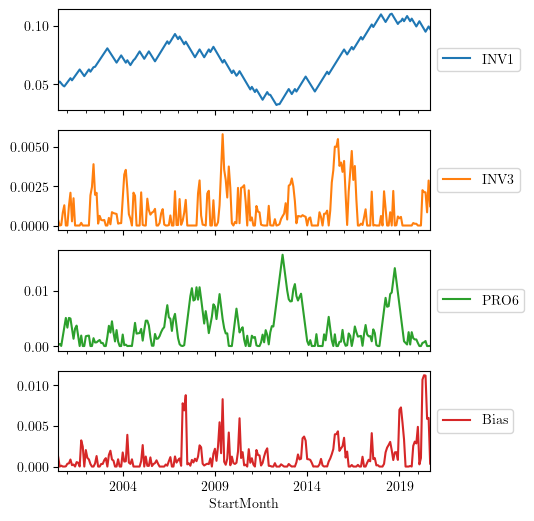

In [56]:
#out_3
#pd.DataFrame(wis_adm, index = weights_svm.index, columns = ['Vol', 'GRW7', 'PRO6', 'INV3', 'LEV5']).plot(subplots = True, legend = True, figsize = (6,9));
pd.DataFrame(np.concatenate([wis_adm, np.expand_dims(bias_adm, axis = 1)], axis = 1), index = weights_svm.index, 
             columns = ['INV1','INV3','PRO6', 'Bias']).plot(subplots = True, legend = True, figsize = (6,6));

for ax in plt.gcf().axes:
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  # Put a legend to the right of the current axis
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(img_path + "p13"+turnover+".svg", dpi = dpi_setting)

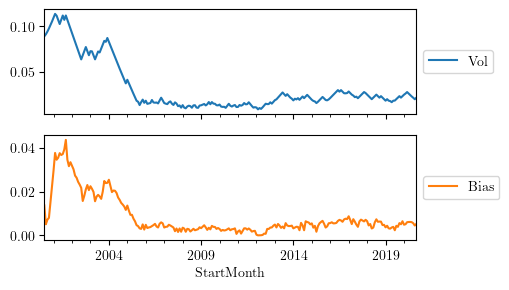

In [57]:
# df = pd.DataFrame(wis_svm, columns= wrds_svm.loc[:,"ROC1":"Vol"].columns, index = weights_svm.index)
# df.mean()
# #plt.legend(['INV3','LEV5']);
# df.ROC1.plot()
bias_svm2 = np.array([bias_svm[i][0] for i in range(len(bias_svm))])
pd.DataFrame(np.concatenate([wis_svm, np.expand_dims(bias_svm2, axis = 1)], axis = 1), index = weights_svm.index, 
             columns = ['Vol', 'Bias']).plot(subplots = True, legend = True, figsize = (6,3));

for ax in plt.gcf().axes:
  box = ax.get_position()
  ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  # Put a legend to the right of the current axis
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(img_path + "p14"+turnover+".png", dpi = dpi_setting)

In [58]:
bias_svm2 = np.array([bias_svm[i][0] for i in range(len(bias_svm))])